# Homework 6

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-06

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on multiple files (from previous weeks):

- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.

-----------------------------------------------------------
# Parametric Credit Models: 
# Nelson-Siegel credit model for smooth hazard rate curves

### This homework  implements some of the concepts introduced in Lecture 6, "Parametric Hazard Rate Models"

### Follow the "Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the "Smooth Credit Models" notebook
### You can also take a look at Dr. Mark Hendricks Fixed Income notebooks describing the Nelson-Siegel model calibration on US Treasuries.
-----------------------------------------------------------

In [18]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Market Data preparation

## a. Prepare the VZ bond market data as of 2024-12-13
Load the symbology + market data dataframes and create a combined dataframe for all Verizon (ticker = 'VZ') fixed rate (cpn_type == 'FIXED') bonds with an outstanding amount greater than $100 MM (amt_out > 100).

Sort the dataframe by bond maturity and display the head of the dataframe.

Plot the VZ yields (Y-axis) by TTM (X-axis).

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,term,TTM,date,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
35,VZ,Corp,BBG00ZLKTF09,US92343VGG32,US91282CLY56,VZ 1.45 03/20/26,VERIZON COMMUNICATIONS,GLOBAL,1.450,FIXED,...,4.993840,1.264887,2024-12-13,96.175,96.327,0.3460,4.605,4.476,96.2510,4.5405
13,VZ,Corp,BBG00DGYP877,US92343VDD38,US91282CLY56,VZ 2 5/8 08/15/26,VERIZON COMMUNICATIONS,GLOBAL,2.625,FIXED,...,10.036961,1.670089,2024-12-13,97.011,97.315,0.8820,4.508,4.313,97.1630,4.4105
18,VZ,Corp,BBG00G6QW2B8,US92343VDY74,US91282CMB45,VZ 4 1/8 03/16/27,VERIZON COMMUNICATIONS,GLOBAL,4.125,FIXED,...,9.998631,2.253251,2024-12-13,98.920,99.067,1.0315,4.633,4.563,98.9935,4.5980
25,VZ,Corp,BBG00SK3XVL1,US92343VFF67,US91282CMB45,VZ 3 03/22/27,VERIZON COMMUNICATIONS,GLOBAL,3.000,FIXED,...,7.003422,2.269678,2024-12-13,96.470,96.700,0.7000,4.657,4.547,96.5850,4.6020
36,VZ,Corp,BBG00ZLKTF27,US92343VGH15,US91282CMA61,VZ 2.1 03/22/28,VERIZON COMMUNICATIONS,GLOBAL,2.100,FIXED,...,7.000684,3.271732,2024-12-13,92.132,92.319,0.4905,4.727,4.661,92.2255,4.6940


Text(0.5, 0, 'Bond TTM')

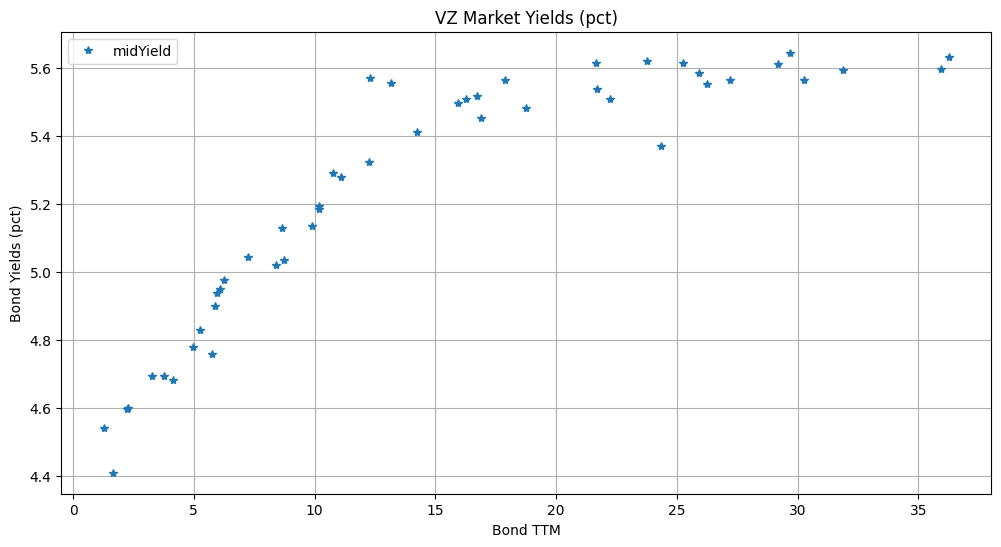

In [19]:
# Load bond_symbology.xlsx
bond_symbology  = pd.read_excel('./data/bond_symbology.xlsx')
bond_symbology  = bond_symbology[bond_symbology['cpn_type'] == 'FIXED']

# Add term and TTM columns
bond_symbology['term'] = (bond_symbology['maturity'] - bond_symbology['start_date']).dt.days / 365.25
bond_symbology['TTM'] = (bond_symbology['maturity'] - as_of_date).dt.days / 365.25

# Load bond_market_prices_eod
bond_market_prices_eod = pd.read_excel('./data/bond_market_prices_eod.xlsx')

# Add mid prices and yields
bond_market_prices_eod['midPrice'] = 0.5*(bond_market_prices_eod['bidPrice'] + bond_market_prices_eod['askPrice'])
bond_market_prices_eod['midYield'] = 0.5*(bond_market_prices_eod['bidYield'] + bond_market_prices_eod['askYield'])


# corp_symbology_vz
corp_symbology_vz = bond_symbology[(bond_symbology.ticker == 'VZ') & (bond_symbology.cpn_type == 'FIXED') & (bond_symbology.amt_out > 100)]

# Create vz_df
vz_df = corp_symbology_vz.merge(bond_market_prices_eod, how='inner', on=['class', 'ticker', 'isin', 'figi'])

# Sort the dataframe by bond maturity and display the head of the dataframe.
vz_df.sort_values('maturity', inplace=True)
display(vz_df.head())

# Plot the VZ yields (Y-axis) by TTM (X-axis).
plt = vz_df.plot(x='TTM', y = 'midYield', figsize = (12, 6), title = "VZ Market Yields (pct)", grid=True, style='*')
plt.set_ylabel('Bond Yields (pct)')
plt.set_xlabel('Bond TTM')


## b. Compute bond yields and risk metrics
For each bond, use the bond market mid-price as an input to compute the:

1. bond yields,
2. bond DV01s and
3. bond durations.

You can use section "9. Analytical Duration" in the QuantLib Basics notebook as a template.


In [20]:
fixed_rate_bond_objects = []
bond_market_prices = []    
bond_yields = []
bond_DV01s = []    
bond_durations = []    

for index,row in vz_df.iterrows():
    fixed_rate_bond = create_bond_from_symbology(row)    
    fixed_rate_bond_objects.append(fixed_rate_bond)
    
    bond_clean_price = row['midPrice']                
    bond_yield = fixed_rate_bond.bondYield(bond_clean_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

    bond_yield_rate = ql.InterestRate(bond_yield/100, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)
    bond_duration = ql.BondFunctions.duration(fixed_rate_bond, bond_yield_rate)
    
    bond_accrued = fixed_rate_bond.accruedAmount()
    bond_dirty_price = bond_clean_price + bond_accrued    
    # bond_dirty_price = fixed_rate_bond.dirtyPrice(bond_yield/100, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)

    bond_DV01   = bond_dirty_price * bond_duration
    
    bond_market_prices.append(bond_clean_price)
    bond_yields.append(bond_yield)
    bond_DV01s.append(bond_DV01)
    bond_durations.append(bond_duration)   


## c. Calibrate the US Treasury curve
### Calibrate the "on-the-run" US Treasury curveas of 2024-12-13:

... to be used in the hazard rate model calibration.

In [21]:
# US Treasury "On-The-Run" yield curve calibration

# Load govt_on_the_run, as of 2024-12-13
govt_on_the_run = pd.read_excel('./data/govt_on_the_run.xlsx')

# Keep OTR treasuries only
govt_on_the_run_simple = govt_on_the_run[~govt_on_the_run['ticker'].str.contains('B|C')]

# Create symbology for on-the-run treasuries only
govt_symbology_otr = bond_symbology[bond_symbology['isin'].isin(govt_on_the_run_simple['isin'])].copy()
govt_symbology_otr = govt_symbology_otr.sort_values(by='maturity')

# Merge market data as of 2024-12-13 into treasury OTR symbology
govt_combined_otr = govt_symbology_otr.merge(bond_market_prices_eod,  on=['class','ticker','figi','isin'])
display(govt_combined_otr.head())

# tsy_yield_curve calibration
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'midPrice')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)


,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,term,TTM,date,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,T,Govt,BBG01QZFYJV6,US91282CLY56,US91282CLY56,T 4 1/4 11/30/26,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,1.993155,1.963039,2024-12-13,100.0000,100.0078,0.1875,4.249,4.245,100.0039,4.2470
1,T,Govt,BBG01R4Z7Y32,US91282CMB45,US91282CMB45,T 4 12/15/27,US TREASURY N/B,US GOVERNMENT,4.000,FIXED,...,2.995209,3.003422,2024-12-13,99.3750,99.3828,0.0117,4.224,4.221,99.3789,4.2225
2,T,Govt,BBG01QZFYD58,US91282CMA61,US91282CMA61,T 4 1/8 11/30/29,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,4.993840,4.963723,2024-12-13,99.4375,99.4453,0.1816,4.252,4.250,99.4414,4.2510
3,T,Govt,BBG01QZFYCF9,US91282CLZ22,US91282CLZ22,T 4 1/8 11/30/31,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,6.992471,6.962355,2024-12-13,98.7969,98.8125,0.1816,4.327,4.324,98.8047,4.3255
4,T,Govt,BBG01QKHSMP5,US91282CLW90,US91282CLW90,T 4 1/4 11/15/34,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,9.998631,9.921971,2024-12-13,98.8125,98.8281,0.3633,4.399,4.397,98.8203,4.3980


-----------------------------------------------------------
# Problem 2: Add functions needed to calibrate the Nelson-Siegel (4 parameters) credit model

## a. For a given set of Nelson-Siegel curve shape parameters, write a function to create the corresponding parametric credit curve.
The result should be a DefaultProbabilityTermStructureHandle object, to be used downstream for pricing.

In [22]:
# nelson_siegel curve shape: Nelson-Siegel
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''    
    
    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    return total_value


def create_nelson_siegel_curve(calc_date, nelson_siegel_params):
    ''' nelson_siegel_params = (theta1, theta2, theta3, lambda)'''            
    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]
    
    # cap and floor survival probs, to ensure they are in (0, 1]
    nelson_siegel_surv_prob_levels = [max(min(x,1),1e-8) for x in nelson_siegel_surv_prob_levels]

    # nelson_siegel_surv_prob_curve
    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)
    
    return(nelson_siegel_credit_curve_handle)

## b. Write a function to price all bonds in the Nelson-Siegel credit model

Use 40% recovery rate.

Using DefaultProbabilityTermStructureHandle as an input to compute all model prices and yields.

In [23]:
def calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # nelson_siegel_surv_prob_curve_handle
    nelson_siegel_surv_prob_curve_handle = create_nelson_siegel_curve(calc_date, nelson_siegel_params)
    
    # nelson_siegel_risky_bond_engine
    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_surv_prob_curve_handle, bond_recovery_rate, tsy_yield_curve_handle)
    
    bond_model_prices = []
    bond_model_yields = []
    
    for fixed_rate_bond in fixed_rate_bond_objects:
        fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)
        
        bond_price = fixed_rate_bond.cleanPrice()                
        bond_yield = fixed_rate_bond.bondYield(bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
        
        bond_model_prices.append(bond_price)
        bond_model_yields.append(bond_yield)
    
    return(bond_model_prices, bond_model_yields)


## c. Write a function to computes the weighted SSE / "Sum of Squared Errors" metric
Write a function to compute the weighted SSE / "Sum of Squared Errors" in price space, defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds.

Use 1/DV01 as SSE weights, as discussed in Lecture 6. You can ignore the liquidity adjuster for the purpose of this exercise.

In [24]:
def nelson_siegel_sse(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      market_prices, 
                      calib_weights,
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # bond_model_prices
    bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate)
    # sse    
    sse = 0
    
    for i in range(len(market_prices)):
        model_error = market_prices[i] - bond_model_prices[i]                
        sse += model_error * model_error * calib_weights[i]                        
    
    return(sse)    


## d. Test the functionalty on the initial set of model parameters: 
## initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]

Compute the corresponding initial model prices and yields, as well as initial SSE.

Add following columns to the VZ dataframe and display the head of the results:

| duration | calib_weight | initModelPrice | initModelYield |
|----------|----------|----------|----------|


In [25]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# initial_nelson_siegel_params
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]
print('initial_nelson_siegel_params:', initial_nelson_siegel_params)

vz_df['duration'] = bond_durations

calib_weights = [1 / d for d in bond_DV01s]
sum_calib_weights = sum(calib_weights)
calib_weights = [x / sum_calib_weights for x in calib_weights]
vz_df['calib_weight'] = calib_weights

init_bond_model_prices, init_bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
vz_df['initModelPrice'] = init_bond_model_prices
vz_df['initModelYield'] = init_bond_model_yields

display(vz_df[['security', 'midPrice', 'initModelPrice', 'calib_weight']].head())

# initial_sse
initial_sse = nelson_siegel_sse(initial_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', initial_sse)


initial_nelson_siegel_params: [0.03, -0.01, 0.02, 5.0]


,security,midPrice,initModelPrice,calib_weight
35,VZ 1.45 03/20/26,96.2510,95.146125,0.100202
13,VZ 2 5/8 08/15/26,97.1630,95.309715,0.075915
18,VZ 4 1/8 03/16/27,98.9935,96.660427,0.056271
25,VZ 3 03/22/27,96.5850,94.369654,0.056752
36,VZ 2.1 03/22/28,92.2255,89.133337,0.041414


initial_sse = 31.203462250780273


-----------------------------------------------------------
# Problem 3: Calibrate the Nelson-Siegel model
## a. Find the Nelson-Siegel model parameters providing the smooth credit curve which best fits the market.

Use the US "on-the-run" Treasury yield curve for risk-free discounting.

Minimize the SSE (model vs market pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

You can use  minimize from scipy.optimize to minimize the SSE.

In [26]:
from scipy.optimize import minimize

def calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_details, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4):
    # create_bonds_and_weights
    # fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(bond_details, tsy_yield_curve_handle)
    
    # start calibration
    param_bounds = [(1e-3, 0.1), (-0.1, 0.1), (-0.1, 0.1), (1e-3, 10)]
            
    calib_results = minimize(nelson_siegel_sse,
                                            initial_nelson_siegel_params, 
                                            args = (calc_date, 
                                                    fixed_rate_bond_objects, 
                                                    bond_market_prices, 
                                                    calib_weights,
                                                    tsy_yield_curve_handle, 
                                                    bond_recovery_rate),
                                            bounds = param_bounds)


    return(calib_results)



In [27]:
# calibrate_nelson_siegel_model
calib_results = calibrate_nelson_siegel_model(initial_nelson_siegel_params, calc_date, vz_df, tsy_yield_curve_handle, bond_recovery_rate)
print(calib_results)
    
# calib_nelson_siegel_params
calib_nelson_siegel_params = calib_results.x
print('calib_nelson_siegel_params:', calib_nelson_siegel_params)

# calib_nelson_siegel_curve
calib_nelson_siegel_curve = create_nelson_siegel_curve(calc_date, calib_nelson_siegel_params)

# calib_sse
calib_sse = nelson_siegel_sse(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', round(initial_sse, 3), 'calib_sse =', round(calib_sse, 3))


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.44305821377190985
        x: [ 3.107e-02 -2.532e-02 -7.456e-03  1.000e+01]
      nit: 38
      jac: [ 2.856e-05  1.580e-05  6.850e-06 -1.190e-03]
     nfev: 240
     njev: 48
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
calib_nelson_siegel_params: [ 3.10673676e-02 -2.53150352e-02 -7.45638697e-03  1.00000000e+01]
initial_sse = 31.203 calib_sse = 0.443


## b. Compute smooth model prices, yields and "edges"

Price all Verizon bonds on the calibrated credit curve and compute the corresponding model yields and edges.

Add following columns to the dataframe and display the head of the results:

| modelPrice | modelYield | edgePrice | edgeYield |
|----------|----------|----------|----------|


In [28]:
# Price all Verizon bonds on the calibrated credit curve and compute the corresponding yields.
bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)

vz_df['modelPrice'] = bond_model_prices
vz_df['modelYield'] = bond_model_yields
vz_df['edgePrice'] = vz_df['modelPrice'] - vz_df['midPrice']
vz_df['edgeYield'] = vz_df['modelYield'] - vz_df['midYield']

display(vz_df[['security', 'midPrice','initModelPrice', 'modelPrice', 'edgePrice']].head())
display(vz_df[['security', 'midYield','initModelYield', 'modelYield', 'edgeYield']].head())

,security,midPrice,initModelPrice,modelPrice,edgePrice
35,VZ 1.45 03/20/26,96.2510,95.146125,96.324503,0.073503
13,VZ 2 5/8 08/15/26,97.1630,95.309715,96.905926,-0.257074
18,VZ 4 1/8 03/16/27,98.9935,96.660427,98.889698,-0.103802
25,VZ 3 03/22/27,96.5850,94.369654,96.561834,-0.023166
36,VZ 2.1 03/22/28,92.2255,89.133337,92.175704,-0.049796


,security,midYield,initModelYield,modelYield,edgeYield
35,VZ 1.45 03/20/26,4.5405,5.483991,4.478419,-0.062081
13,VZ 2 5/8 08/15/26,4.4105,5.614381,4.575337,0.164837
18,VZ 4 1/8 03/16/27,4.5980,5.724514,4.647622,0.049622
25,VZ 3 03/22/27,4.6020,5.679874,4.612931,0.010931
36,VZ 2.1 03/22/28,4.6940,5.798073,4.711261,0.017261


-----------------------------------------------------------
# Problem 4: Visualize the results of the credit model calibration

## a. Plot the model vs market prices (Y-axis) by maturity (X-axis).

Text(0.5, 0, 'Bond Maturity')

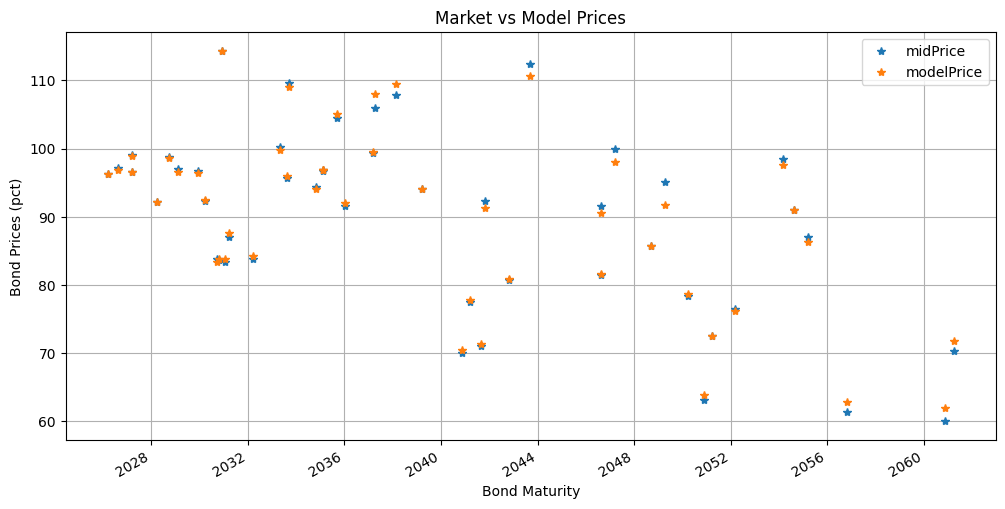

In [29]:
# Plot the model vs market prices (Y-axis) by maturity (X-axis).
plt = vz_df.plot(x='maturity', y = ['midPrice', 'modelPrice'], figsize = (12, 6), title = "Market vs Model Prices", grid=True, style='*')
plt.set_ylabel('Bond Prices (pct)')
plt.set_xlabel('Bond Maturity')


## b. Plot the model vs market yields (Y-axis) by maturity (X-axis).

Text(0.5, 0, 'Bond Maturity')

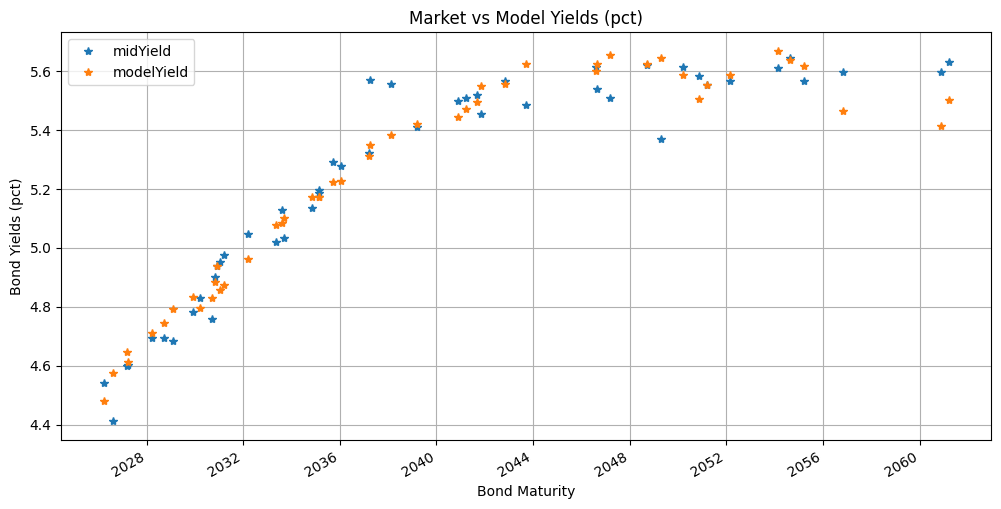

In [30]:
# Plot the model vs market yields (Y-axis) by maturity (X-axis).
plt = vz_df.plot(x='maturity', y = ['midYield', 'modelYield'], figsize = (12, 6), title = "Market vs Model Yields (pct)", grid=True, style='*')
plt.set_ylabel('Bond Yields (pct)')
plt.set_xlabel('Bond Maturity')


## c. Plot the edges in yield space (Y-axis) by maturity (X-axis).

Text(0.5, 0, 'Bond Maturity')

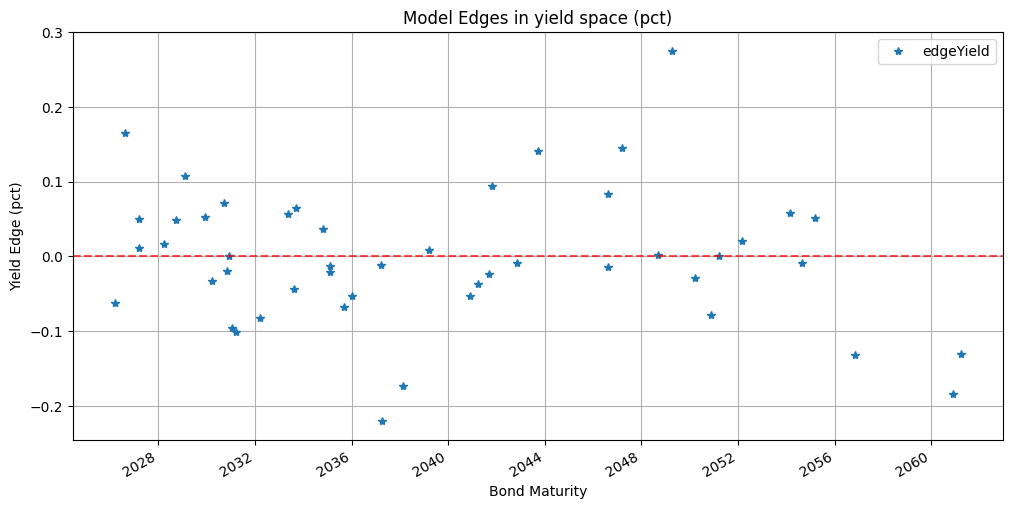

In [31]:
# Plot the edges in yield space (Y-axis) by maturity (X-axis).
plt = vz_df.plot(x='maturity', y = ['edgeYield'], figsize = (12, 6), title = "Model Edges in yield space (pct)", grid=True, style='*')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('Yield Edge (pct)')
plt.set_xlabel('Bond Maturity')


## d. What do you think about the quality of the model fit?

Model fit looks good, given that fact that we are matching closely the market prices about 50 VZ bonds with only 4 Nelson-Siegel model parameters.